# All the examples in the book: *Regression Graph Models for Categorical Data*

M. Lupparelli, G. M. Marchetti, C. Tarantola

15 May 2024

## Example 1.3 - Lawyer’s ratings of state judges

There are 12 ratings for 43 judges. 

In [52]:
library(datasets)
data(USJudgeRatings)
dim(USJudgeRatings)

[1] 43 12

The variables `INTG` (judicial integrity), `DILG` (diligence) and `CONT` (number of contacts of lawyer with judge) are observed on 43 judges. The sample correlation is obtained.

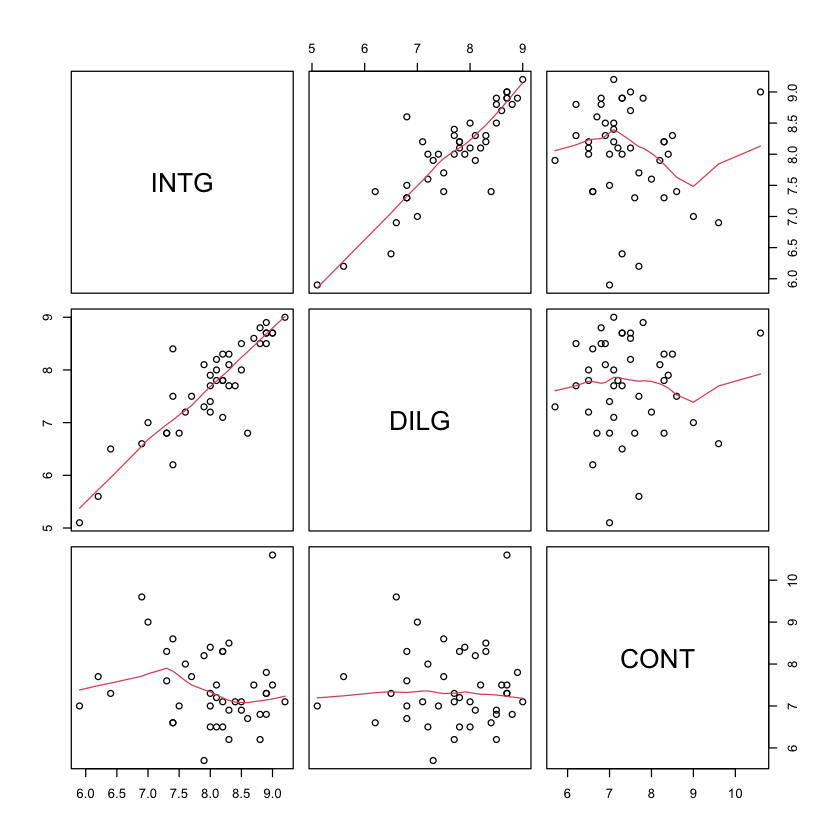

In [53]:
data_judge <- USJudgeRatings[, c("INTG", "DILG", "CONT")]
pairs(data_judge,panel = panel.smooth)

In [54]:
R <- cor(data_judge)
round(R, 3)

,INTG,DILG,CONT
INTG,1.000,0.872,-0.133
DILG,0.872,1.000,0.012
CONT,-0.133,0.012,1.000


In [55]:
summary(lm( CONT ~ INTG*DILG, data = data_judge) )


Call:
lm(formula = CONT ~ INTG * DILG, data = data_judge)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6239 -0.5936 -0.1044  0.3760  3.2609 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 11.95514    8.87769   1.347    0.186
INTG        -1.11281    1.19567  -0.931    0.358
DILG         0.14547    1.26868   0.115    0.909
INTG:DILG    0.05279    0.15694   0.336    0.738

Residual standard error: 0.9319 on 39 degrees of freedom
Multiple R-squared:  0.08902,	Adjusted R-squared:  0.01894 
F-statistic:  1.27 on 3 and 39 DF,  p-value: 0.2979


The $F$ statistic for the hypothesis $CONT \perp\!\!\!\perp INTG, DILG$ is not rejected.

The bi-directed graph shown below represents the joint independence.  

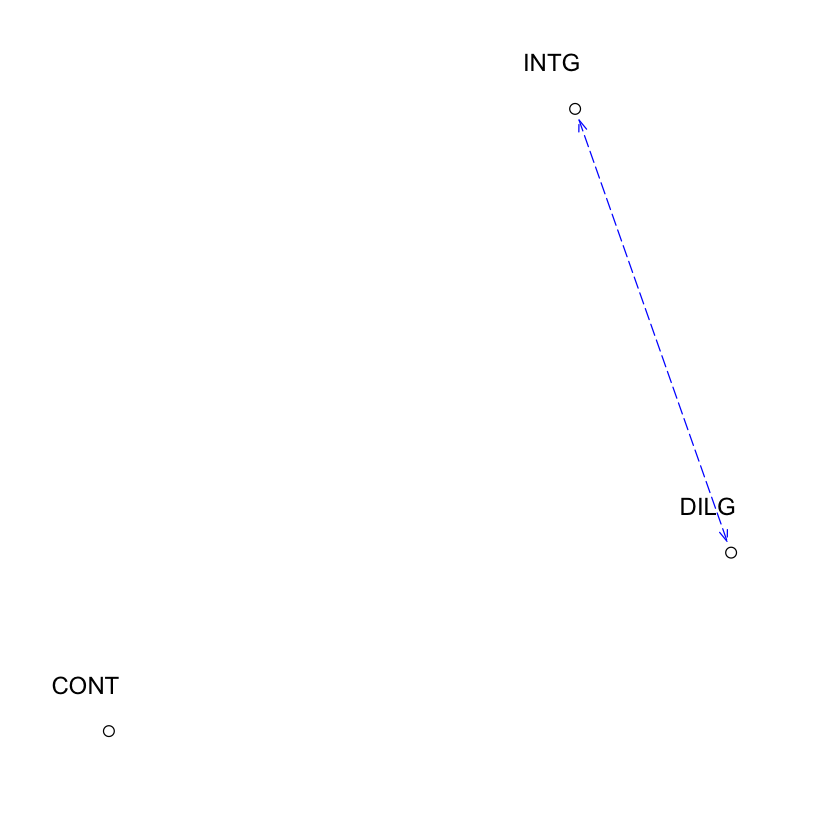

In [56]:
G <- 100 * UG(~ CONT + INTG*DILG)
drawGraph(G)

## Example 1.8 - Fiji Fertility Survey

Variables 
- `A`, Age
- `M` Age at first marriage 
- `E` Education 𝐸 (in completed years)
- `U` Residence  (urban = 1 or rural = 0), 
- `F` Fertility  (number of children ever born), 

observed on a sample of 774 married women of Fijian ethnicity, aged 35-49.


In [57]:
fiji <- read.csv("./data/fiji_data2.csv")
fijians <- fiji[fiji$I == 0,-5]
print(dim(fijians))
summary(fijians)

[1] 774   5


       F                A               M               E         
 Min.   : 0.000   Min.   :35.00   Min.   :10.00   Min.   : 0.000  
 1st Qu.: 3.000   1st Qu.:38.00   1st Qu.:17.00   1st Qu.: 5.000  
 Median : 6.000   Median :41.00   Median :19.00   Median : 6.000  
 Mean   : 5.452   Mean   :41.06   Mean   :19.73   Mean   : 5.871  
 3rd Qu.: 8.000   3rd Qu.:44.00   3rd Qu.:22.00   3rd Qu.: 7.000  
 Max.   :14.000   Max.   :49.00   Max.   :44.00   Max.   :20.000  
       U         
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.2726  
 3rd Qu.:1.0000  
 Max.   :1.0000  

### The Full regression graph 

To create an adjacency matrix for a RC graph we are going to use the package **ggm**. The main
function used is `makeMG` (make a mixed graph). 

In [58]:
library("ggm")
gfull <- makeMG(dg = DAG(F ~ M+E+A+U, M ~ U + A,  E ~ U + A), 
                bg = UG(~ M*E +  U*A))
gfull

,F,M,E,A,U
F,0,0,0,0,0
M,1,0,100,0,0
E,1,100,0,0,0
A,1,1,1,0,100
U,1,1,1,100,0


Plot the graph 

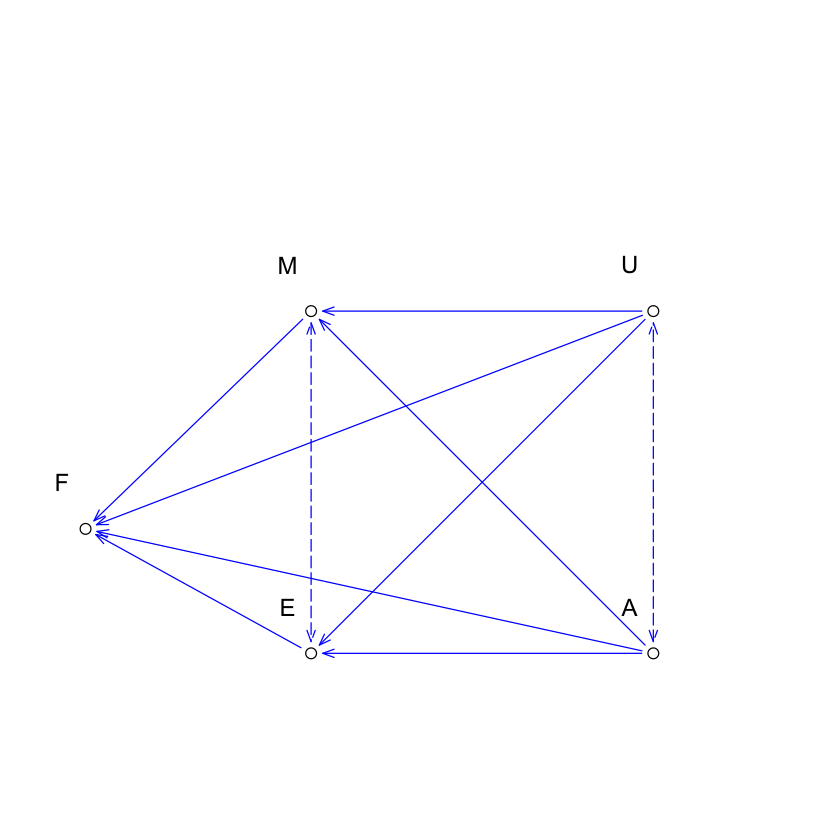

In [59]:
co <- matrix(c(
    7, 36, 36, 64, 36, 20, 80, 20, 80, 64
), byrow = TRUE, ncol = 2)
drawGraph(gfull, coor = co)

### Fit a regression model for fertility 

In [60]:
m1 <- lm(F ~ M + E + A + U, data = fijians)
round(summary(m1)$coef, 3) 

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),5.285,1.200,4.404,0.000
M,-0.206,0.024,-8.546,0.000
E,0.009,0.044,0.210,0.834
A,0.111,0.025,4.388,0.000
U,-1.389,0.232,-5.997,0.000


Suggest removing arrow $F \leftarrow E$

In [61]:
m2 <- lm(M ~ A + U , data = fijians)
round(summary(m2)$coef, 3)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),19.709,1.544,12.768,0.000
A,0.007,0.037,0.195,0.846
U,-1.007,0.344,-2.926,0.004


Suggest removing arrow $M \leftarrow A$

In [62]:
m3 <- lm(E ~ A + U , data = fijians)
round(summary(m3)$coef, 3)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),9.822,0.846,11.607,0.00
A,-0.099,0.020,-4.812,0.00
U,0.343,0.189,1.817,0.07


Perhaps we can remove the arrow $E \leftarrow U$

The reduced regression graph

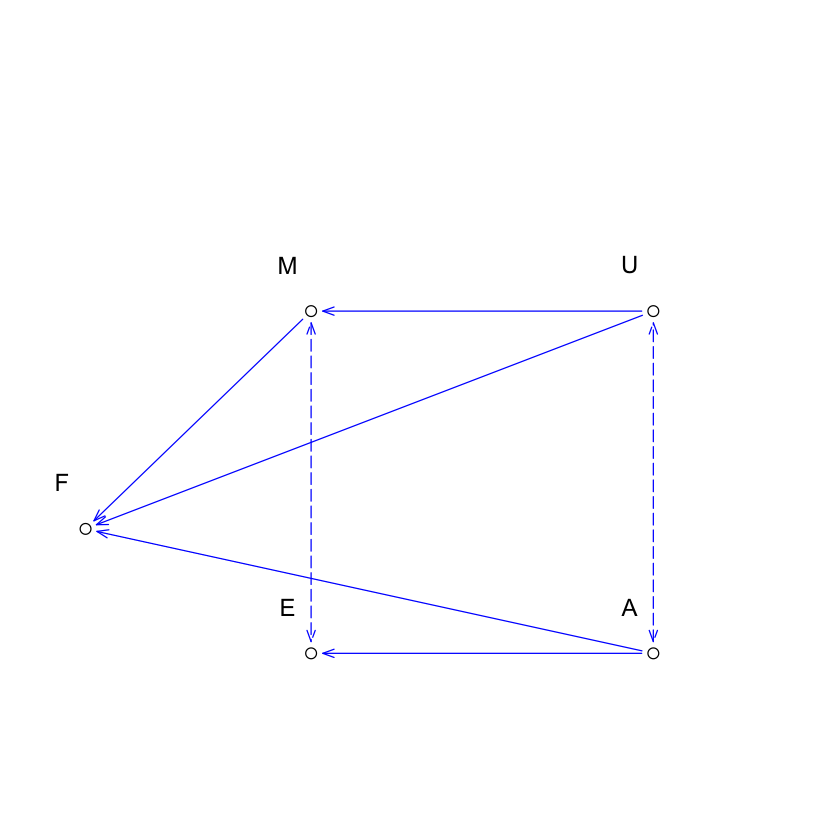

In [63]:
gred <- gfull
gred["E", "F"] <- 0
gred["A", "M"] <- 0
gred["U", "E"] <- 0
drawGraph(gred, coor = co)

### MLE fit using package **sem**

Structural equations for the saturated model

In [64]:
library("sem")

In [65]:
sat_mod_F <- specifyModel(text="
M -> F, bFM, NA
A -> F, bFA, NA
U -> F, bFU, NA
E -> F, bFE, NA
U -> M, bMU, NA
A -> M, bMA, NA
A -> E, bEA, NA
U -> E, bEU, NA
F <-> F, oFF, NA
M <-> M, oMM, NA
M <-> E, oME, NA
E <-> E, oEE, NA
A <-> A, oAA, NA
A <-> U, oAU, NA
U <-> U, oUU, NA
")

NOTE: it is generally simpler to use specifyEquations() or cfa()
      see ?specifyEquations



In [66]:
S <- cov(fijians)
m_sat <-  sem(sat_mod_F, S, N = 774, start.tol = 1e-09)
summary(m_sat)


 Model Chisquare =  -6.865619e-13   Df =  0 Pr(>Chisq) = NA
 AIC =  30
 BIC =  -6.865619e-13

 Normalized Residuals
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-2.741e-15 -3.027e-16  0.000e+00 -3.973e-17  3.639e-16  1.248e-15 

 R-square for Endogenous Variables
     M      F      E 
0.0110 0.1335 0.0331 

 Parameter Estimates
    Estimate     Std Error  z value     Pr(>|z|)             
bFM -0.206025906 0.02404668 -8.56774948 1.055271e-17 F <--- M
bFA  0.110974275 0.02522646  4.39912135 1.086900e-05 F <--- A
bFU -1.388761080 0.23099040 -6.01220252 1.830195e-09 F <--- U
bFE  0.009244430 0.04386276  0.21075804 8.330761e-01 F <--- E
bMU -1.007277214 0.34380453 -2.92979621 3.391844e-03 M <--- U
bMA  0.007265717 0.03729347  0.19482543 8.455296e-01 M <--- A
bEA -0.098507206 0.02044523 -4.81810270 1.449298e-06 E <--- A
bEU  0.342845890 0.18848235  1.81898137 6.891427e-02 E <--- U
oFF  8.055230086 0.40973513 19.65960325 4.784540e-86 F <--> F
oMM 18.141375148 0.92277422

Reduced model

In [67]:
red_mod_F <- specifyModel(text="
M -> F, bFM, NA
A -> F, bFA, NA
U -> F, bFU, NA
U -> M, bMU, NA
A -> E, bEA, NA
F <-> F, oFF, NA
M <-> M, oMM, NA
M <-> E, oME, NA
E <-> E, oEE, NA
A <-> A, oAA, NA
A <-> U, oAU, NA
U <-> U, oUU, NA
")
m_red <-  sem(red_mod_F, S, N = 774, start.tol = 1e-09)
summary(m_red)

NOTE: it is generally simpler to use specifyEquations() or cfa()
      see ?specifyEquations




 Model Chisquare =  3.384157   Df =  3 Pr(>Chisq) = 0.3361003
 AIC =  27.38416
 BIC =  -16.57056

 Normalized Residuals
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.22861 -0.04188  0.00000  0.13696  0.01545  1.78854 

 R-square for Endogenous Variables
     M      F      E 
0.0121 0.1335 0.0292 

 Parameter Estimates
    Estimate     Std Error  z value     Pr(>|z|)             
bFM -0.205613746 0.02396717 -8.57897348 9.572354e-18 F <--- M
bFA  0.110060638 0.02485130  4.42876696 9.477336e-06 F <--- A
bFU -1.385176505 0.23050041 -6.00943175 1.861747e-09 F <--- U
bMU -1.057957966 0.34266787 -3.08741516 2.019054e-03 M <--- U
bEA -0.098737351 0.02041987 -4.83535602 1.329075e-06 E <--- A
oFF  8.055692965 0.40975867 19.65960325 4.784540e-86 F <--> F
oMM 18.142192602 0.92281581 19.65960325 4.784540e-86 M <--> M
oME  0.812115820 0.35966271  2.25799283 2.394611e-02 E <--> M
oEE  5.475282718 0.27850423 19.65960325 4.784540e-86 E <--> E
oAA 16.874382837 0.85832774 19.65960325 4.78454

### Fitting the multivariate regression chain graph

The regression chain graphs is a special case of  ancestral graph. 
Thus you can use the function `fitAncestralGraph` in package **ggm**.
Source also the file `dome_functions.R`.

In [68]:
source("./R/some_functions.R")

Saturated model

In [69]:
library("ggm")
out_sat <- fitAncestralGraph(gfull, S, n = 774)
summaryRCG(out_sat, n = 774)

      beta    se     LB     UB
F|A  0.111 0.025  0.046  0.176
M|A  0.007 0.037 -0.089  0.103
E|A -0.099 0.020 -0.151 -0.046
F|M -0.206 0.024 -0.268 -0.144
F|E  0.009 0.044 -0.104  0.122
F|U -1.389 0.231 -1.984 -0.793
M|U -1.007 0.344 -1.894 -0.121
E|U  0.343 0.188 -0.143  0.829
     omega    se     LB     UB
F~F  8.055 0.409  6.999  9.112
A~A 16.874 0.858 14.661 19.087
U~A  0.005 0.093 -0.235  0.245
M~M 18.141 0.922 15.762 20.521
E~M  0.809 0.506 -0.496  2.113
M~E  0.809 0.506 -0.496  2.113
E~E  5.452 0.277  4.737  6.167
A~U  0.005 0.093 -0.235  0.245
U~U  0.199 0.010  0.173  0.225


Reduced model

In [70]:
out_red <- fitAncestralGraph(gred, S, n = 774, tol = 1e-09)
summaryRCG(out_sat, n = 774)

      beta    se     LB     UB
F|A  0.111 0.025  0.046  0.176
M|A  0.007 0.037 -0.089  0.103
E|A -0.099 0.020 -0.151 -0.046
F|M -0.206 0.024 -0.268 -0.144
F|E  0.009 0.044 -0.104  0.122
F|U -1.389 0.231 -1.984 -0.793
M|U -1.007 0.344 -1.894 -0.121
E|U  0.343 0.188 -0.143  0.829
     omega    se     LB     UB
F~F  8.055 0.409  6.999  9.112
A~A 16.874 0.858 14.661 19.087
U~A  0.005 0.093 -0.235  0.245
M~M 18.141 0.922 15.762 20.521
E~M  0.809 0.506 -0.496  2.113
M~E  0.809 0.506 -0.496  2.113
E~E  5.452 0.277  4.737  6.167
A~U  0.005 0.093 -0.235  0.245
U~U  0.199 0.010  0.173  0.225


## Example 1.13 Data on Women's Labour-Force Participation

The original data are in R package **carData**.
The first 3 variables are transformed to binary data.
The resulting variables are all categorical.

In [35]:
wlf_data <- read.table("./data/wlfdata.txt", header = TRUE, colClasses = "character")
wlf_data <- as.data.frame(lapply(wlf_data, factor))
ftable(R ~ H + C + L, data = wlf_data)

ERROR: Error in eval(expr, envir, enclos): object 'wlfdata' not found


### Test conditional independency

You need package **bnlearn** for this. 

In [ ]:
library(bnlearn)
ci.test( "H", "C", "L", data = wlf_data, test = "mi")


	Mutual Information (disc.)

data:  H ~ C | L
mi = 0.38496, df = 2, p-value = 0.8249
alternative hypothesis: true value is greater than 0


Response $L$: Fit an additive logistic model

In [ ]:
m_add1 <- glm(L ~ C + H + R, family = binomial, data = wlf_data)
round(summary(m_add1)$coef, 3)

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),1.041,0.607,1.715,0.086
C1,-2.609,0.361,-7.234,0.000
H1,-0.768,0.348,-2.210,0.027
RBC,-0.944,0.745,-1.266,0.206
ROntario,-0.254,0.590,-0.430,0.667
RPrairie,0.168,0.695,0.241,0.809
RQuebec,-0.342,0.627,-0.545,0.586


This suggests to remove the arrow $L \leftarrow R$.  The reduced model is below with a 
likelihood ratio test. 

In [ ]:
m_red1 <- glm(L ~ C + H, family = binomial, data = wlf_data)
summary(m_red1)
print(anova(m_red1, m_add1, test = "Chisq"))


Call:
glm(formula = L ~ C + H, family = binomial, data = wlf_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.6834     0.2797   2.443   0.0146 *  
C1           -2.4404     0.3346  -7.294 3.02e-13 ***
H1           -0.7896     0.3397  -2.324   0.0201 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 296.34  on 262  degrees of freedom
Residual deviance: 228.31  on 260  degrees of freedom
AIC: 234.31

Number of Fisher Scoring iterations: 5


Analysis of Deviance Table

Model 1: L ~ C + H
Model 2: L ~ C + H + R
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1       260     228.31                     
2       256     225.50  4   2.8117   0.5898


Response $C$: fit an additive model 

In [ ]:
m_add2 <- glm(C ~ H + R, family = binomial, data = wlf_data)
round(summary(m_add2)$coef, 3)

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),1.671,0.551,3.030,0.002
H1,0.437,0.282,1.546,0.122
RBC,-1.827,0.656,-2.785,0.005
ROntario,-1.092,0.579,-1.886,0.059
RPrairie,-0.136,0.730,-0.186,0.852
RQuebec,-1.250,0.598,-2.089,0.037


The predictor $H$ is not significant. The reduced model is 

In [ ]:
m_red2 <- glm(C~ R, family = binomial, data = wlfdata)
round(summary(m_red2)$coef, 3)

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),1.872,0.537,3.485,0.000
RBC,-1.803,0.653,-2.760,0.006
ROntario,-1.051,0.576,-1.823,0.068
RPrairie,-0.223,0.726,-0.307,0.759
RQuebec,-1.270,0.596,-2.129,0.033


Analysis of Deviance Table

Model 1: C ~ R
Model 2: C ~ H + R
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1       258     308.54                     
2       257     306.13  1   2.4135   0.1203


Response $H$: fit a multinomial logit model

In [ ]:
m_3 <- glm(H ~ R, family = binomial, data = wlf_data)
round(summary(m_3)$coef, 3)
m_red3 <- glm(H ~ 1, family = binomial, data = wlfdata)
anova(m_red3, m_3, test = "Chisq")

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.000,0.365,0.000,1.000
RBC,0.069,0.521,0.132,0.895
ROntario,0.298,0.414,0.721,0.471
RPrairie,-0.894,0.538,-1.660,0.097
RQuebec,-0.279,0.443,-0.629,0.529


[1] 355.3078

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,262,364.5004,NA,NA,NA
2,258,355.3078,4,9.19254,0.05646299


The LRT statistic is $9.19$ with $4$ d.f. denotes some evidence against the independence of $H$ on $R$.  

## Example 2.1 - Lienert data

In [37]:
source("./data/lienert.R")  # this creates a vector `p` of joint probabilities
lienert <- cbind(expand.grid(X1 = c(0,1), X2 = c(0,1), X3 = c(0,1) ), Freq = p)
tab <- xtabs(Freq ~ ., lienert)
ftable(X3+X2 ~ X1, tab)

   X3  0     1   
   X2  0  1  0  1
X1               
0     21  5  4 16
1      2 13 11  1

## Example 2.6 - The Coppen data

In [ ]:
Freq <- c(15, 30, 9, 32, 23, 22, 14, 16,25,22,46,27,14,8,47,12)
X <- expand.grid(X2 = factor(1:2), X4 = factor(1:2), X1 = factor(1:2), X3 = c("y", "n"))
coppen <- cbind(X, Freq)
coppen

X2,X4,X1,X3,Freq
<fct>,<fct>,<fct>,<fct>,<dbl>
1,1,1,y,15
2,1,1,y,30
1,2,1,y,9
2,2,1,y,32
1,1,2,y,23
2,1,2,y,22
1,2,2,y,14
2,2,2,y,16
1,1,1,n,25
